In [1]:
# import things

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2023-11-02 13:26:04.340543: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 13:26:04.361744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]


In [3]:
print(tf.__version__)
print(torch.__version__)

2.14.0
2.1.0+cu121


In [30]:
# Make Data
N_dat   = 100000
X_intercept = np.random.uniform(-30,30,N_dat)# in degrees
cosTheta    = np.random.uniform(-0.9,0.9,N_dat)

m = np.tan(np.arccos(cosTheta))
b = X_intercept*m 

(1.6, 30.4)

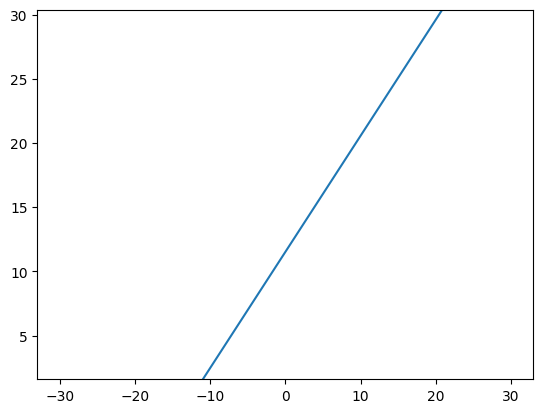

In [31]:
x = np.linspace(min(X_intercept),max(X_intercept),N_dat)
i = np.random.randint(N_dat)

y = m[i]*x + b[i]

plt.plot(x,y)
plt.ylim(1.6,30.4)

In [32]:
grid_rows,grid_cols = 22,20
grid_size = 1.5
grid_centre_x,grid_centre_y = 0,16.8
Grid = np.zeros((N_dat,grid_rows,grid_cols))

grid_row_edges = np.linspace(1.6,30.4,grid_rows+1)
grid_col_edges = np.linspace(-15,15,grid_cols+1)
print(grid_col_edges)

for k,(m_val,b_val) in enumerate(zip(m,b)):
    print('k',end='\r')
    for i,(y1,y2) in enumerate(zip(grid_row_edges[:-1],grid_row_edges[1:])):
        for j,(x1,x2) in enumerate(zip(grid_col_edges[:-1],grid_col_edges[1:])):
            line1 = m_val*x1 + b_val
            line2 = m_val*x2 + b_val
            if ((line1-y1)*(line2-y2) <= 0) or ((line1-y2)*(line2-y1) <= 0):
                Grid[k,i,j] = 1

[-15.  -13.5 -12.  -10.5  -9.   -7.5  -6.   -4.5  -3.   -1.5   0.    1.5
   3.    4.5   6.    7.5   9.   10.5  12.   13.5  15. ]


71645
22.0
[-15.0, 15.0, 1.6, 30.4]
-88.81634517810849
-48.39893126667061


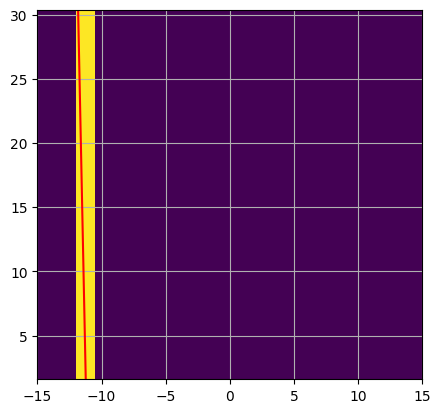

In [33]:
while True:
    n = np.random.randint(N_dat)
    if np.sum(Grid[n]) > 5:
        print(n)
        print(np.sum(Grid[n]))
        # print(Grid[n])
        break
# Plot grid
fig, ax = plt.subplots()
ax.set_aspect('equal','box')
ax.set_ylim(1.6,30.4)
ax.set_xlim(-15,15)


extent = [grid_col_edges[0], grid_col_edges[-1], grid_row_edges[0], grid_row_edges[-1]]
ax.imshow(Grid[n],origin = 'lower',extent=extent)
print(extent)
X = np.linspace(-15,15)
Y = m[n]*(X) + b[n]
plt.plot(X,Y,'r')
plt.grid()
# plt.ylim(0,22)
# # plt.xlim(0,20)
print(np.arctan(m[n])/np.pi*180)
print(m[n])

In [34]:
Data = Grid[Grid.sum(axis=(1,2))>5]

TrueX = np.sqrt(1/(1+m**2))
TrueY = m*TrueX
TrueX = TrueX[Grid.sum(axis=(1,2))>5]
TrueY = TrueY[Grid.sum(axis=(1,2))>5]


# Add New Axis to Data
Data = np.expand_dims(Data,axis=3)

print(Data.shape)
print(TrueX.shape)
print(TrueY.shape)

# Data = torch.from_numpy(Data).float()
# TrueX = torch.from_numpy(TrueX).float()
# TrueY = torch.from_numpy(TrueY).float()
# Truth = torch.stack((TrueX,TrueY),dim=1)

(61376, 22, 20, 1)
(61376,)
(61376,)


In [9]:
# Assuming Data, TrueX, TrueY are already defined and properly shaped
# Data shape should be (num_samples, 22, 20, 1)
# TrueX, TrueY shape should be (num_samples,)

# Define the model
# inpShape = (1,22,20)
channels1st = 'channels_first'
if channels1st == 'channels_first':
    if Data.shape[1] == 1:
        inpShape = (1,22,20)
        print('No Need to reshape data')
        # pass
    if Data.shape[1] != 1:
        print('Reshaping data')
        inpShape = (1,22,20)
        Data = np.moveaxis(Data,3,1)
elif channels1st == 'channels_last':
    inpShape = (22,20,1)
print(Data.shape)

modelTF = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=inpShape,data_format=channels1st),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)  # Output 2 parameters: unit vector components (x, y)
])

# Compile the model
modelTF.compile(optimizer='adam',
              loss='mse')

# Prepare labels as a single array of shape (num_samples, 2)
labels = tf.stack([TrueX, TrueY], axis=1)

# Train the model
modelTF.fit(Data, labels, epochs=10, batch_size=32)

# To predict
# predictions = model.predict(some_input_data)


Reshaping data
(61169, 1, 22, 20)
Epoch 1/10
1912/1912 [==============================] - 6s 3ms/step - loss: 0.0266
Epoch 2/10
1912/1912 [==============================] - 5s 3ms/step - loss: 0.0176
Epoch 3/10
1912/1912 [==============================] - 6s 3ms/step - loss: 0.0160
Epoch 4/10
1912/1912 [==============================] - 6s 3ms/step - loss: 0.0150
Epoch 5/10
1912/1912 [==============================] - 6s 3ms/step - loss: 0.0146
Epoch 6/10
1912/1912 [==============================] - 6s 3ms/step - loss: 0.0139
Epoch 7/10
1912/1912 [==============================] - 6s 3ms/step - loss: 0.0134
Epoch 8/10
1912/1912 [==============================] - 6s 3ms/step - loss: 0.0131
Epoch 9/10
1912/1912 [==============================] - 5s 3ms/step - loss: 0.0130
Epoch 10/10
1912/1912 [==============================] - 5s 3ms/step - loss: 0.0129


In [10]:
preds = modelTF.predict(Data[:10000,...])
truth = labels[:10000,...]

313/313 [==============================] - 0s 882us/step


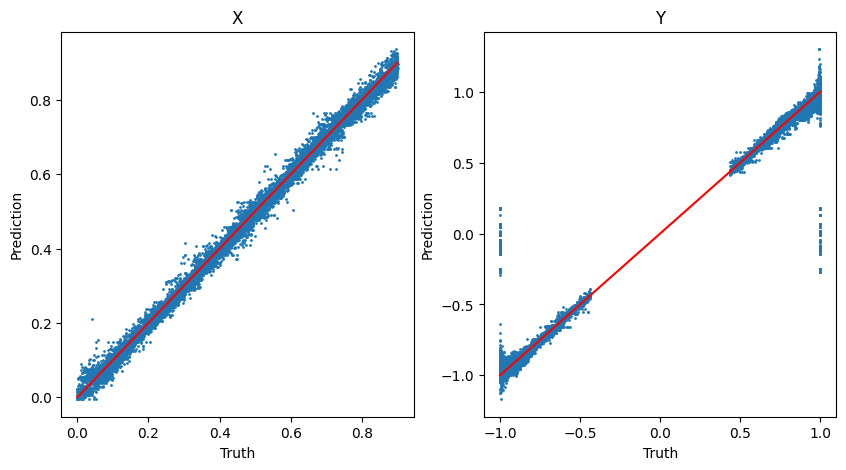

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(truth[:,0],preds[:,0],s=1)
ax[0].plot([min(truth[:,0]),max(truth[:,0])],[min(truth[:,0]),max(truth[:,0])],'r')
ax[0].set_xlabel('Truth')
ax[0].set_ylabel('Prediction')
ax[0].set_title('X')
ax[1].scatter(truth[:,1],preds[:,1],s=1)
ax[1].plot([min(truth[:,1]),max(truth[:,1])],[min(truth[:,1]),max(truth[:,1])],'r')
ax[1].set_xlabel('Truth')
ax[1].set_ylabel('Prediction')
ax[1].set_title('Y')
plt.show()

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming Data, TrueX, TrueY are already defined and properly shaped
# Convert them to PyTorch tensors

Data = torch.tensor(Data, dtype=torch.float32)
TrueX = torch.tensor(TrueX, dtype=torch.float32)
TrueY = torch.tensor(TrueY, dtype=torch.float32)

Data = Data.squeeze().unsqueeze(1)
# Data = Data.to('cpu')
# labels = labels.to('cpu')

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.fc1 = nn.Linear(32 * 20 * 18, 10)
        self.fc2 = nn.Linear(10, 2)
        
        # # Weight initialization to match TensorFlow
        # nn.init.xavier_uniform_(self.conv1.weight)
        # nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
if True:
    Losses = []
    modelPT = Net()

    # Compile the model
    optimizer = optim.Adam(modelPT.parameters(),lr=0.001)
    criterion = nn.MSELoss()
    # optimizer.param_groups[0]['lr'] *= 0.5
    # print(optimizer.param_groups[0]['lr'])
    # Prepare labels as a single array of shape (num_samples, 2)
    labels = torch.stack([TrueX, TrueY], dim=1)
if False:
    optimizer.param_groups[0]['lr'] *= 0.5
    print()
    print('Reducing Learning Rate to: ',optimizer.param_groups[0]['lr'])


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, Main, Truth):
        self.Main = Main
        self.Truth = Truth
    def __len__(self):
        return len(self.Main)
    def __getitem__(self, idx):
        return self.Main[idx,:,:,:], self.Truth[idx,:]
    
data_set = MyDataset(Data,labels)

DataLoader = torch.utils.data.DataLoader(data_set, batch_size=32, shuffle=True)

# Train the model
for epoch in range(1,10):  
    for i, (BatchData, Batchlabels) in enumerate(DataLoader):
        # print('Epoch', epoch)
        outputs = modelPT(BatchData)
        loss = criterion(outputs, Batchlabels)
        Losses.append(loss.item())
        print('Epoch:',epoch,'Loss', loss.item(),end='\r')
        optimizer.zero_grad()
        loss.backward()
        # for name,param in modelPT.named_parameters():
        #     if param.requires_grad:
        #         if 'c' in name:
        #             print(name,param.grad)
        optimizer.step()
    
# To predict
# predictions = model(some_input_data)


/tmp/ipykernel_22891/2858650270.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Data = torch.tensor(Data, dtype=torch.float32)
/tmp/ipykernel_22891/2858650270.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TrueX = torch.tensor(TrueX, dtype=torch.float32)
/tmp/ipykernel_22891/2858650270.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TrueY = torch.tensor(TrueY, dtype=torch.float32)


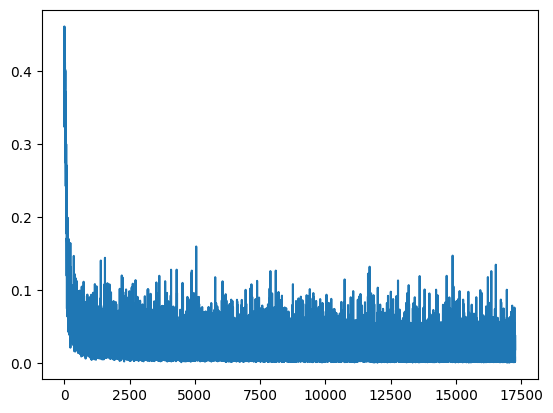

In [50]:
plt.plot(Losses)

In [51]:
print(modelPT.conv1.weight.shape)
print(modelPT.conv1.bias.shape)
print(modelPT.fc1.weight.shape)
print(modelPT.fc1.bias.shape)
print(modelPT.fc2.weight.shape)
print(modelPT.fc2.bias.shape)


torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([10, 11520])
torch.Size([10])
torch.Size([2, 10])
torch.Size([2])


In [52]:
modelPT.eval()
preds = modelPT(Data[:10000,...])
print(preds.device)
preds = preds.detach().numpy()
truth = labels[:10000,...]

cpu


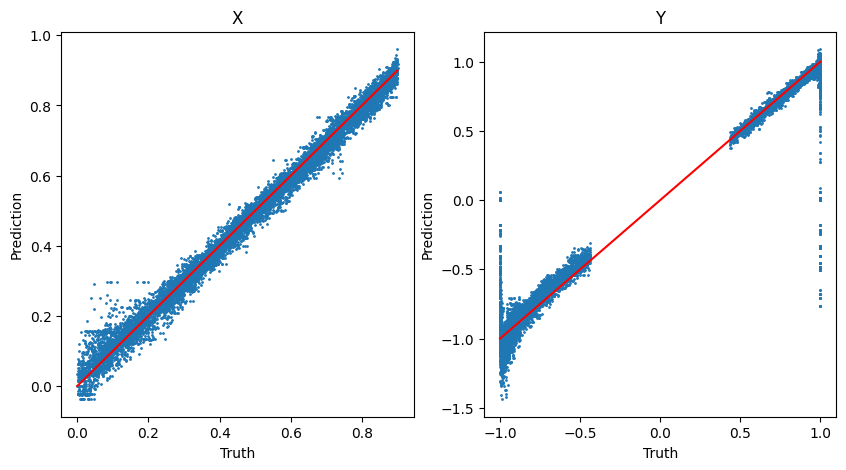

In [53]:

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(truth[:,0],preds[:,0],s=1)
ax[0].plot([min(truth[:,0]),max(truth[:,0])],[min(truth[:,0]),max(truth[:,0])],'r')
ax[0].set_xlabel('Truth')
ax[0].set_ylabel('Prediction')
ax[0].set_title('X')
ax[1].scatter(truth[:,1],preds[:,1],s=1)
ax[1].plot([min(truth[:,1]),max(truth[:,1])],[min(truth[:,1]),max(truth[:,1])],'r')
ax[1].set_xlabel('Truth')
ax[1].set_ylabel('Prediction')
ax[1].set_title('Y')
plt.show()

In [208]:
# # Assuming Data, TrueX, TrueY are already defined and properly shaped
# Data = torch.tensor(Data, dtype=torch.float32)
# TrueX = torch.tensor(TrueX, dtype=torch.float32)
# TrueY = torch.tensor(TrueY, dtype=torch.float32)

# Data = Data.squeeze().unsqueeze(1)

# # Using Sequential for the model
# modelPT = nn.Sequential(
#     nn.Conv2d(1, 32, (3, 3)),
#     nn.Flatten(),
#     nn.Linear(32 * 20 * 18, 128),
#     nn.ReLU(),
#     nn.Linear(128, 2)
# )

# # Weight initialization to match the original
# for layer in modelPT:
#     if hasattr(layer, 'weight'):
#         nn.init.xavier_uniform_(layer.weight)

# # Compile the model
# optimizer = optim.Adam(modelPT.parameters())
# criterion = nn.MSELoss()

# # Prepare labels as a single array of shape (num_samples, 2)
# labels = torch.stack([TrueX, TrueY], dim=1)

# # Train the model
# for epoch in range(10):
#     print('Epoch', epoch, end='\r')
#     optimizer.zero_grad()
#     outputs = modelPT(Data)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()

# # To predict
# # predictions = model(some_input_data)


In [209]:
# model.eval()
# preds = model(Data[:10000,...])
# print(preds.device)
# preds = preds.detach().numpy()
# truth = labels[:10000,...]

In [210]:
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# ax[0].scatter(truth[:,0],preds[:,0],s=1)
# ax[0].plot([min(truth[:,0]),max(truth[:,0])],[min(truth[:,0]),max(truth[:,0])],'r')
# ax[0].set_xlabel('Truth')
# ax[0].set_ylabel('Prediction')
# ax[0].set_title('X')
# ax[1].scatter(truth[:,1],preds[:,1],s=1)
# ax[1].plot([min(truth[:,1]),max(truth[:,1])],[min(truth[:,1]),max(truth[:,1])],'r')
# ax[1].set_xlabel('Truth')
# ax[1].set_ylabel('Prediction')
# ax[1].set_title('Y')
# plt.show()

In [211]:
# # Replace PT weights with TF weights
# # 1. Extract weights and biases from TensorFlow model
# conv1_weights_tf = modelTF.layers[0].get_weights()[0]  # shape (3, 3, 1, 32)
# conv1_biases_tf = modelTF.layers[0].get_weights()[1]   # shape (32,)

# fc1_weights_tf = modelTF.layers[2].get_weights()[0]    # shape (32 * 20 * 18, 128)
# fc1_biases_tf = modelTF.layers[2].get_weights()[1]     # shape (128,)

# fc2_weights_tf = modelTF.layers[3].get_weights()[0]    # shape (128, 2)
# fc2_biases_tf = modelTF.layers[3].get_weights()[1]     # shape (2,)

# # 2. Convert to PyTorch format (Transpose where necessary)

# conv1_weights_pt = torch.tensor(np.transpose(conv1_weights_tf, (3, 2, 0, 1)), dtype=torch.float32)
# conv1_biases_pt = torch.tensor(conv1_biases_tf, dtype=torch.float32)


# fc1_weights_pt = torch.tensor(np.transpose(fc1_weights_tf), dtype=torch.float32)
# fc1_weights_pt = fc1_weights_pt.view(128, -1)  # Flatten to shape (128, 32 * 20 * 18)
# fc1_biases_pt = torch.tensor(fc1_biases_tf, dtype=torch.float32)

# fc2_weights_pt = torch.tensor(np.transpose(fc2_weights_tf), dtype=torch.float32)
# fc2_biases_pt = torch.tensor(fc2_biases_tf, dtype=torch.float32)

# # 3. Load into PyTorch model
# with torch.no_grad():
#     modelPT.conv1.weight.copy_(conv1_weights_pt)
#     modelPT.conv1.bias.copy_(conv1_biases_pt)
#     modelPT.fc1.weight.copy_(fc1_weights_pt)  # Adjusted line
#     modelPT.fc1.bias.copy_(fc1_biases_pt)
#     modelPT.fc2.weight.copy_(fc2_weights_pt)
#     modelPT.fc2.bias.copy_(fc2_biases_pt)

In [212]:
# print(modelPT.conv1.weight.shape)
# print(modelPT.conv1.bias.shape)
# print(modelPT.fc1.weight.shape)
# print(modelPT.fc1.bias.shape)
# print(modelPT.fc2.weight.shape)
# print(modelPT.fc2.bias.shape)


In [213]:
modelPT.eval()
preds = modelPT(Data[:10000,...])
print(preds.device)
preds = preds.detach().numpy()
truth = labels[:10000,...]

cpu


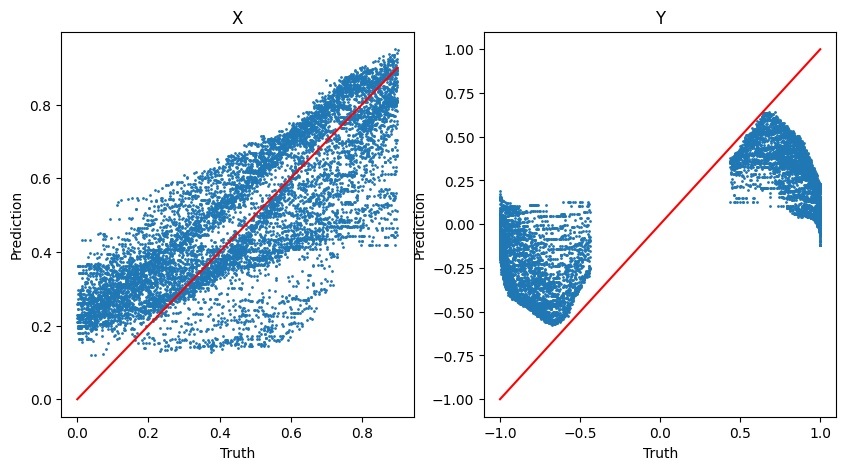

In [214]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(truth[:,0],preds[:,0],s=1)
ax[0].plot([min(truth[:,0]),max(truth[:,0])],[min(truth[:,0]),max(truth[:,0])],'r')
ax[0].set_xlabel('Truth')
ax[0].set_ylabel('Prediction')
ax[0].set_title('X')
ax[1].scatter(truth[:,1],preds[:,1],s=1)
ax[1].plot([min(truth[:,1]),max(truth[:,1])],[min(truth[:,1]),max(truth[:,1])],'r')
ax[1].set_xlabel('Truth')
ax[1].set_ylabel('Prediction')
ax[1].set_title('Y')
plt.show()